In [9]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich import print

from apps.prod4a_merge_study import (EventSelection, PFOSelection,
                                     ShowerMergeQuantities, SignalBackground,
                                     SplitSample)
from python.analysis import Master, Plots
plt.style.use('ggplot')

In [2]:
def Quantile(data : ak.Array) -> np.array:
    """ Calculates the 0-99th percentile for a given dataset.

    Args:
        data (ak.Array): dataset

    Returns:
        np.array: array of percentiles
    """
    return np.percentile(ak.to_numpy(data), range(100))


def GetSignal(data : ak.Array, signal : ak.Array) -> ak.Array:
    """ Apply signal mask to data from ShowerMergeQuantities.

    Args:
        data (ak.Array): data
        signal (ak.Array): signal mask

    Returns:
        ak.Array: selected PFOs
    """
    s = [data[j][np.logical_or(*signal)] for j in range(2)]
    s = ak.min(ak.concatenate(ak.unflatten(s, 1, -1), -1), -1) # take the smallest value as the signal
    return s


def GetBackground(data : ak.Array, background : ak.Array) -> ak.Array:
    """ Apply signal mask to data from ShowerMergeQuantities.

    Args:
        data (ak.Array): data
        background (ak.Array): background mask

    Returns:
        ak.Array: selected PFOs
    """
    return ak.ravel([data[j][background[0]] for j in range(2)])


def PlotControl():
    """ Plot line of perfect fit.
    """
    control = Quantile(np.linspace(0, 100, 101))
    control = control/max(control) # normalise to show plots to scale
    Plots.Plot(control, control, "background", "signal", label="control")


def TestPlots(nx : int = 2000, ny : int = 2000, mu_x : float = 4, mu_y : float = 4, sigma_x : float = 10, sigma_y : float = 10):
    """ Make quantile plots of test data to understand how they should be interpreted.

    Args:
        nx (int, optional): size of x sample. Defaults to 2000.
        ny (int, optional): size of x sample. Defaults to 2000.
        mu_x (float, optional): mean of x. Defaults to 4.
        mu_y (float, optional): mean of y. Defaults to 4.
        sigma_x (float, optional): standard deviation of x. Defaults to 10.
        sigma_y (float, optional): standard deviation of y. Defaults to 10.
    """
    # two datasets which have the same distribution shapes but different number of samples
    x = abs(np.random.normal(mu_x, sigma_x, nx))
    y = abs(np.random.normal(mu_y, sigma_y, ny))
    qx = Quantile(x)
    qy = Quantile(y)
    
    scale_factor = max(qx) if max(qx) > max(qy) else max(qy) # scale the plot so you can compare this with other qq plots more easily
    qx = qx / scale_factor
    qy = qy / scale_factor
    Plots.Plot(qx, qy, "background", "signal", label="test", newFigure=False)
    Plots.PlotHistComparison([x, y], labels=["x", "y"], density=False)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/sb16

PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_00  \
$\alpha$ (rad)                                            0.193540   
$\delta x$ (cm)                                           0.365061   
$\delta x_{l}$ (cm)                                       0.375135   
$\delta x_{t}$ (cm)                                       0.397808   
$\delta\phi$ (rad)                                        0.154940   
d (cm)                                                    0.434618   
t (cm)                                                    0.390073   
p (cm)                                                    0.350009   

                     PDSPProd4a_MC_6GeV_reco1_sce_datadriven_v1_00  difference  
$\alpha$ (rad)                                            0.212019   -0.018479  
$\delta x$ (cm)                                           0.322919    0.042142  
$\delta x_{l}$ (cm)                                       0.331305    0.043830  
$\delta x_{t}$ (cm)                                       0.363141    0.034667  
$\delta\phi$ (rad)                                        0.142605    0.012334  
d (cm)                                                    0.409256    0.025362  
t (cm)                                                    0.346359    0.043714  
p (cm)                                                    0.278175    0.071834

/tmp/ipykernel_14102/3116558259.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex("Quantile_area_table")


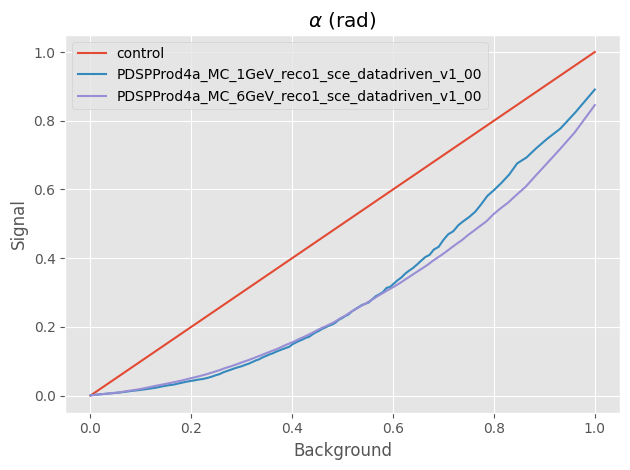

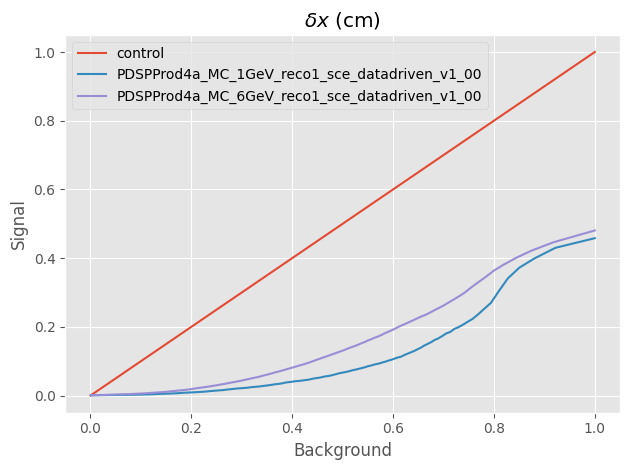

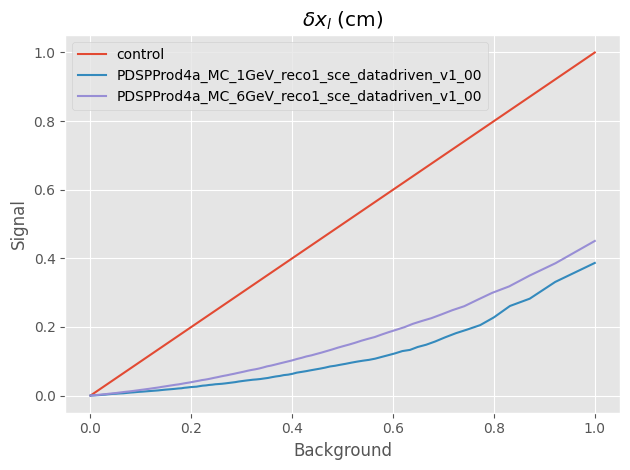

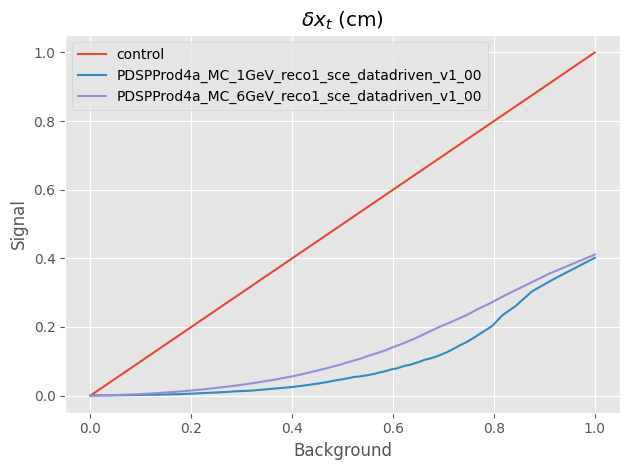

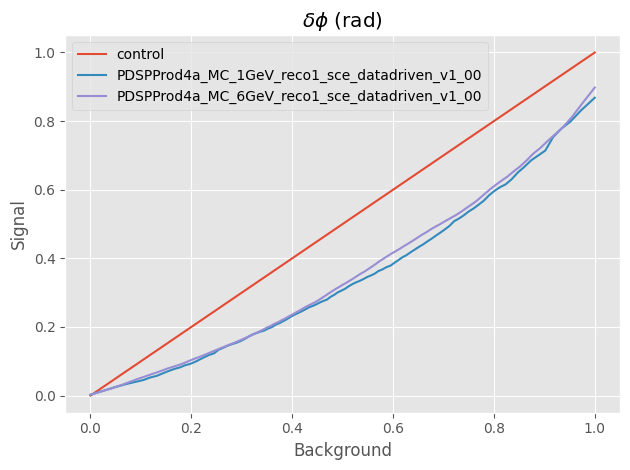

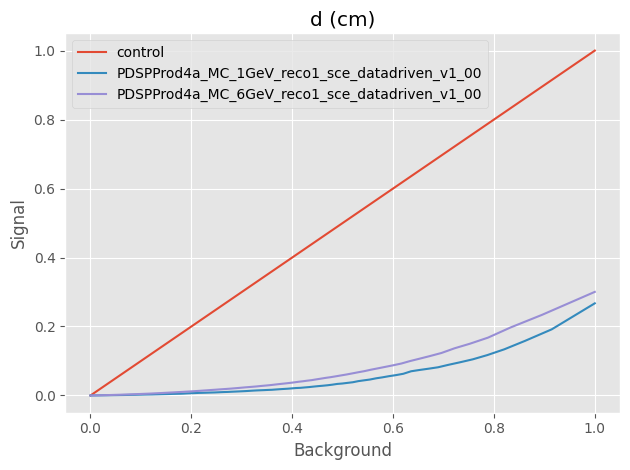

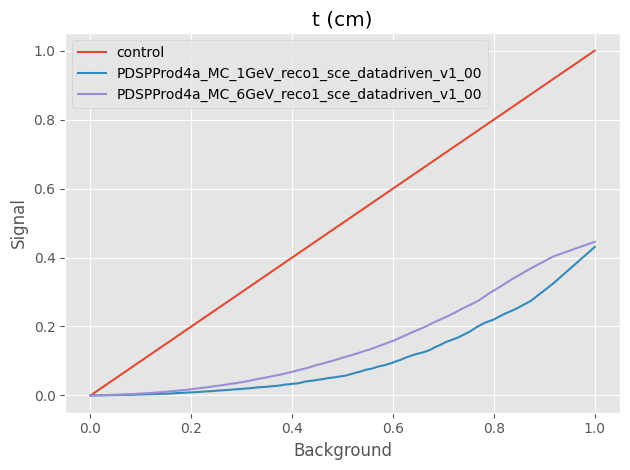

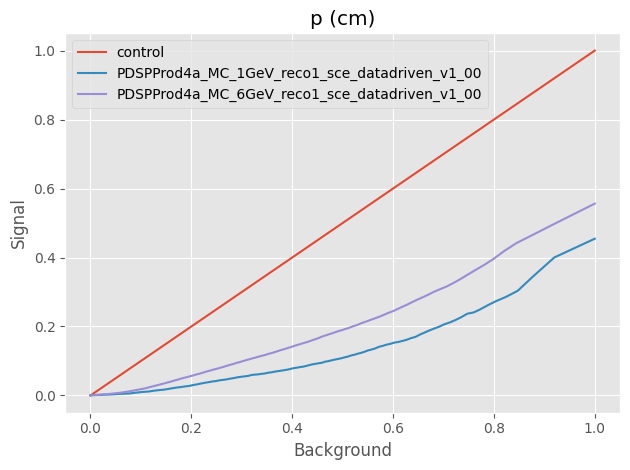

In [16]:
file_list = ["csv/merge-quantities/merge-quantities-1GeV.csv", "csv/merge-quantities/merge-quantities-6GeV.csv"]
quantities = {"PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_00" : None, "PDSPProd4a_MC_6GeV_reco1_sce_datadriven_v1_00": None}

# open data
for k, f in zip(list(quantities.keys()), file_list):
    q = ShowerMergeQuantities()
    q.LoadQuantitiesFromCSV(f)
    quantities[k] = q

# make qq plots
table = pd.DataFrame()
for v, v_names in zip(ShowerMergeQuantities.selectionVariables, ShowerMergeQuantities.xlabels):
    PlotControl()
    areas = {}
    for sample_name, sample in quantities.items():
        s = Quantile(GetSignal(getattr(sample, v) , getattr(sample, "signal")))
        b = Quantile(GetBackground(getattr(sample, v), getattr(sample, "background")))
        
        scale_factor = max(s) if max(s) > max(b) else max(b) # scale the plot so you can compare this with other qq plots more easily
        s = s/scale_factor # normalise to show plots to scale
        b = b/scale_factor # normalise to show plots to scale

        areas[sample_name] = 0.5 - np.trapz(s, b) # 0.5 is the area under the straight line

        Plots.Plot(b, s, "Background", "Signal", newFigure=False, label=sample_name, title=v_names)
    table = pd.concat([table, pd.DataFrame(areas, index = [v_names])])
    # Plots.Save(f"qq_{v}", "test/")
delta = table[list(quantities.keys())[0]] - table[list(quantities.keys())[1]]
table = pd.concat([table, pd.DataFrame({"difference" : delta})], axis = 1)
print(table)
# table.to_latex("Quantile_area_table")

In [ ]:
events_1GeV = Master.Data("work/ROOTFiles/Prod4a_1GeV_BeamSim_00.root")
events_6GeV = Master.Data("work/ROOTFiles/Prod4a_6GeV_BeamSim_00.root")
events_1GeV.io.ListNTuples()

In [ ]:
EventSelection(events_1GeV)
PFOSelection(events_1GeV)
EventSelection(events_6GeV)
PFOSelection(events_6GeV)
start_showers_1GeV, to_merge_1GeV = SplitSample(events_1GeV)
start_showers_6GeV, to_merge_6GeV = SplitSample(events_6GeV)

In [ ]:
s_1GeV, b_1GeV, s_all_1GeV = SignalBackground(events_1GeV, start_showers_1GeV, to_merge_1GeV)
s_6GeV, b_6GeV, s_all_6GeV = SignalBackground(events_6GeV, start_showers_6GeV, to_merge_6GeV)
ns_1GeV = ak.num(s_all_1GeV[s_all_1GeV])
ns_6GeV = ak.num(s_all_6GeV[s_all_6GeV])

print(ns_1GeV)
print(ns_6GeV)

nbins =  max(ak.concatenate([ns_6GeV, ns_1GeV])) - min(ak.concatenate([ns_6GeV, ns_1GeV]))
Plots.PlotHistComparison([ns_1GeV, ns_6GeV], bins = np.arange(nbins)-0.5, xlabel = "shower multiplicity", labels = ["PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_00", "PDSPProd4a_MC_6GeV_reco1_sce_datadriven_v1_00"])

Plots.Save("nPFO_signal_comparison", "test/")


#nbins =  max(ak.concatenate([ns_6GeV, ns_1GeV])) - min(ak.concatenate([ns_6GeV, ns_1GeV]), 0)
high = max(ak.concatenate([ns_6GeV, ns_1GeV]))
low = min(ak.concatenate([ns_6GeV, ns_1GeV]))
nbins = (high if high <= 12 else 12) - (low if low >= 0 else 0)
Plots.PlotHistComparison([ns_1GeV, ns_6GeV], [-1, 20], bins = np.arange(nbins)-0.5, xlabel = "shower multiplicity", labels = ["PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_00", "PDSPProd4a_MC_6GeV_reco1_sce_datadriven_v1_00"])

Plots.Save("nPFO_signal_comparison_zoom", "test/")